# Contextual analytic geometric descent

## TODOs

* Outer loop plots.
* \>2 contexts, potentially with structure imposed.
* Geometric descent (makes gradient updates independent of gate-parameterization).
* Add gradient flows.

In [1]:
import functools

import numpy as np

from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy.interpolate

from timeit import default_timer as timer
from datetime import timedelta

from qutip import basis, expect
from qutip.qip.operations import rx, rz

from qutip.operators import sigmax
from qutip.qip.operations import snot

# Local imports
from spectator_env_v2 import SpectatorEnvContinuousV2
from spectator_env_utils_v2 import extract_theta_phi, plot, plot_layered, ParallelSimResult, get_error_unitary

In [2]:
from platform import python_version

print(python_version())

3.7.4


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Helper functions

In [4]:
def context_loss(meas, trans):
    return np.var([np.pi - np.arccos(
        np.sqrt(t.overlap(meas) * meas.overlap(t))) for t in trans])


def correction_loss(meas, trans):
    return np.mean([np.pi - np.arccos(
        np.sqrt(t.overlap(meas) * meas.overlap(t))) for t in trans])


# This is the contour of the "true loss" for correction and contextualization.
def get_contour(error_samples, loss_fn, sensitivity=1.0):
    prepared_basis = [snot() * basis(2, 0), snot() * sigmax() * basis(2, 0)]
    trans = [get_error_unitary(sample, sensitivity) * prepared_basis[0]
             for sample in error_samples]

    thetas = np.linspace(0, np.pi, 33)
    phis = np.linspace(-np.pi, np.pi, 33)
    loss = np.zeros((len(thetas), len(phis)))

    min_phi = 0.
    min_theta = 0.
    min_loss = 1.

    max_phi = 0.
    max_theta = 0.
    max_loss = 0.
    for i, theta in enumerate(thetas):
        for j, phi in enumerate(phis):
            meas = np.cos(theta / 2) * prepared_basis[0] + np.exp(
                1j * phi) * np.sin(theta / 2) * prepared_basis[1]
            meas = meas.unit()

            objective = loss_fn(meas, trans)
            if (np.abs(objective) < min_loss):
                min_loss = objective
                min_phi = phi
                min_theta = theta
            if (np.abs(objective) > max_loss):
                max_loss = objective
                max_phi = phi
                max_theta = theta
            loss[i][j] = np.abs(objective)
    return {'thetas': thetas, 'phis': phis, 'loss': loss,
            'max_phi': max_phi, 'max_theta': max_theta,
            'min_phi': min_phi, 'min_theta': min_theta}

## Optimization algorithm

In [5]:
# Optimized action for a conditioning of the overall error distribution.
class Context:
    def __init__(self, gamma, eta, correction_theta_init):
        # Discount factor.
        # This parameter is deprecated given that we rely on gradient updates
        # to adjust to non-stationarity.
        self.gamma = gamma
        # Gradient step size.
        self.eta = eta

        # Feedback which is batched until we decide to use it.
        self.batch_correction_feedback = ([], [], [])
        self.correction_theta = correction_theta_init

        self.grads = [0, 0, 0]

    def reset(self):
        self.batch_correction_feedback = ([], [], [])

    def discount(self):
        pass

    def update_gamma(self, gamma):
        self.gamma = gamma

    def update_batch_feedback(self, correction_feedback, idx):
        self.batch_correction_feedback[idx].append(correction_feedback)

    def combine_correction_feedback(self):
        # feedback is given per variational param
        for idx, f in enumerate(self.batch_correction_feedback):
            if len(f) == 0:
                continue
            lo = np.array([r[0] for r in f])
            hi = np.array([r[1] for r in f])
            lo = np.array(list(map(lambda x: -1 if x == 0 else 1, lo.flatten())))
            hi = np.array(list(map(lambda x: -1 if x == 0 else 1, hi.flatten())))

            mu_plus = np.mean(hi)
            mu_minus = np.mean(lo)

            grad = mu_plus - mu_minus

            self.correction_theta[idx] -= self.eta * grad
            self.grads[idx] = grad

        self.reset()

    def get_optimal_params(self):
        return self.correction_theta, self.grads

In [6]:
# Contextual analytic geometric descent
class Analytic2D:
    def __init__(self, env, initial_gamma=1.0, context_eta=np.pi/64,
                 correction_eta=np.pi/64, context_theta_init=[0, 0, 0],
                 correction_theta_init=[[0, 0, 0], [0, 0, 0]]):
        # Contexts are defined in terms of a function on spectator outcomes.
        # Each context learns an optimal correction independently.
        self.contexts = [Context(initial_gamma, correction_eta,
                                 correction_theta_init[0]),
                         Context(initial_gamma, correction_eta,
                                 correction_theta_init[1])]

        self.num_context_spectators = env.num_context_spectators

        # step size
        self.eta = context_eta

        self.batch_context_feedback = ([], [], [])
        self.context_theta = context_theta_init

        self.grads = [0, 0, 0]

    def get_actions(self, observations=None, batch_size=1):
        # Our context is an array of binary spectator qubit measurements.
        # Hence, we could convert this binary array to an integer and index
        # 2^(spectator qubits) contexts.
        # For now, we only have two contexts (+ vs -), and so we consider
        # spectators to be indistinguishable noise polling devices.
        # In the future, we may consider noise gradients and so we do indeed
        # need to track the specific arrangement.

        if observations is None:
            return [{'context': self.context_theta} for i in range(batch_size)]

        actions = []
        for observation in observations:
            context_idx = (1 if np.sum(observation) >
                           self.num_context_spectators / 2 else 0)
            context = self.contexts[context_idx]

            optimal_correction, correction_grad = context.get_optimal_params()
            actions.append(
                {'correction': optimal_correction,
                 'correction_grad': correction_grad,
                 'context_grad': self.grads,
                 'context': self.context_theta})
        return actions

    def combine_correction_feedback(self):
        for context in self.contexts:
            context.combine_correction_feedback()

    def combine_contextual_feedback(self):
        # Feedback is given per gate parameter.
        for idx, f in enumerate(self.batch_context_feedback):
            if len(f) == 0:
                continue
            lo = np.array([r[0] for r in f])
            mid = np.array([r[1] for r in f])
            hi = np.array([r[2] for r in f])

            lo = np.array(list(map(lambda x: -1 if x == 0 else 1,
                                   lo.flatten())))
            mid = np.array(list(map(lambda x: -1 if x == 0 else 1,
                                    mid.flatten())))
            hi = np.array(list(map(lambda x: -1 if x == 0 else 1,
                                   hi.flatten())))

            mean_mid = np.mean(mid)
            mean_lo = np.mean(lo)
            mean_hi = np.mean(hi)
            var_grad = np.mean([2 * (m - mean_mid)
                                * ((h - l) - (mean_hi - mean_lo))
                                for l, m, h in zip(lo, mid, hi)])
            self.grads[idx] = var_grad

            self.context_theta[idx] += self.eta * var_grad
        self.reset()

    def reset(self):
        self.batch_context_feedback = ([], [], [])

    def update_correction_feedback(self, correction_feedback, observations):
        # Feedback is given per variational param.
        for idx in range(len(self.context_theta)):
            for _correction_feedback, observation in zip(
                    correction_feedback[idx], observations):
                context_idx = (1 if np.sum(observation) >
                               self.num_context_spectators / 2 else 0)
                context = self.contexts[context_idx]
                context.update_batch_feedback(_correction_feedback, idx)

    def update_context_feedback(self, context_feedback, observations):
        # Feedback is given per variational param.
        for idx in range(len(self.context_theta)):
            for _context_feedback, observation in zip(
                    context_feedback[idx], observations):
                self.batch_context_feedback[idx].append(_context_feedback)

    def _update_gammas(self, gamma):
        for context in self.contexts:
            context.update_gamma(gamma)

## Simulation

In [7]:
'''
Hyperparameters
'''


# Spectators can used for two types of feedback:
# (1) Improving the contextual conditioning.
# (2) Improving the correction given each contextual conditioning.
def feedback_spectators_allocation_function():
    feedback_alloc = {}
    feedback_alloc['correction'] = NUM_REWARD_SPECTATORS / 2
    feedback_alloc['context'] = (NUM_REWARD_SPECTATORS
                                 - feedback_alloc['correction'])
    return feedback_alloc


def error_samples_generator(mu, sigma, m):
    # return np.random.choice([mu - sigma, mu + sigma], m)
#     return list(zip(np.random.uniform(mu[0] - sigma[0], mu[0] + sigma[0], m),
#                 np.random.uniform(mu[1] - sigma[1], mu[1] + sigma[1], m)))
    # return np.random.normal(MU, SIGMA, M) # + time_dependent_fn(np.arange(M))
    return list(zip(np.random.normal(mu[0], sigma[0], m),
                 np.random.normal(mu[1], sigma[1], m),  np.random.normal(mu[2], sigma[2], m)))


# Total number of simultaneous measurements (time-steps) per epoch.
M = 8
# Number of measurements (time-steps) per algorithm iteration.
# For simplicity in presentation, it is recommended to match this to M.
BATCH_SIZE = M

# Number of epochs to run simulation.
NUM_EPOCHS = 20
# Total number of algorithm iterations until simulation completion.
# (M // BATCH_SIZE) is the number of batches per epoch.
MAX_FRAMES = NUM_EPOCHS * M // BATCH_SIZE

# Redraw error samples from potentially shifted distribution.
NUM_EPOCHS_TO_REDRAW_ERRORS = 1

# Error distribution.
# May add some random harmonics.
# time_dependent_fn = (np.vectorize(lambda x: (2/5) * np.pi
#                      * np.sin(2 * np.pi * x / M)))
MU_1 = 0
SIGMA_1 = np.pi / 4
MU_2 = 0
SIGMA_2 = np.pi / 64
MU_3 = 0
SIGMA_3 = np.pi / 128
ERROR_SAMPLES = error_samples_generator([MU_1, MU_2, MU_3], [SIGMA_1, SIGMA_2, SIGMA_3], M)

# Gradient step sizes.
CONTEXT_ETA = np.pi / 16
CORRECTION_ETA = np.pi / 16

# Initialization of U3 Gates.
CONTEXT_THETA_INIT = [0, 0, np.pi/4]
CORRECTION_THETA_INIT = [[0, 0, 0], [0, 0, 0]]

# Length of bit-string used to condition error distribution.
NUM_CONTEXT_SPECTATORS = 60
# Number of qubits available for measuring feedback w.r.t a desired objective.
# Use a multiple of 12 for simplicity of analytic gradient computation.
# Mod 12 requirement not actually necessary in practical setting.
NUM_REWARD_SPECTATORS = 60

CONTEXT_SENSITIVITY = 1.0
REWARD_SENSITIVITY = 1.0

# Feedback is collected in batches, but variational parameters can be
# updated after an arbitrary number of batches.
NUM_BATCHES_TO_COMBINE_CONTEXT_FEEDBACK = 1
NUM_BATCHES_TO_COMBINE_CORRECTION_FEEDBACK = 1

In [8]:
# describes MDP
# - states are given in terms of a #context_spectators bit measurement outcomes
# - continuous action space is given by [-pi, pi]^3 single-qubit gate
# parameterization.
env = SpectatorEnvContinuousV2(ERROR_SAMPLES, batch_size=BATCH_SIZE,
                               num_context_spectators=NUM_CONTEXT_SPECTATORS,
                               context_sensitivity=CONTEXT_SENSITIVITY,
                               reward_sensitivity=REWARD_SENSITIVITY)

In [9]:
context_contour = get_contour(ERROR_SAMPLES, context_loss)
print(context_contour['max_phi'], context_contour['max_theta'])

-1.5707963267948966 1.2762720155208536


In [10]:
# start = timer()

# md = Analytic2D(env, context_eta=CONTEXT_ETA,
#                 correction_eta=CORRECTION_ETA,
#                 context_theta_init=CONTEXT_THETA_INIT,
#                 correction_theta_init=CORRECTION_THETA_INIT)


# data_fidelity_per_episode = []
# spectator_fidelity_per_episode = []
# control_fidelity_per_episode = []
# data_fidelity = []
# spectator_fidelity = []
# control_fidelity = []

# # "episodes" are a reasonable way to think about learning a periodic
# # time-dependent function.
# # max frames = episode length * num episodes
# # episodes are identical sequences of training data
# init_actions = md.get_actions(batch_size=BATCH_SIZE)
# observation = env.reset(init_actions)

# correction_2d_repr = {}
# context_2d_repr = []

# correction_grads = {}
# context_grads = []

# # context outcomes per episode
# context_outcome_hist = {}

# batches_per_epoch = M // BATCH_SIZE
# # Frames are given in terms of the number of batches of measurements.
# for frame_idx in range(1, MAX_FRAMES + 1):
#     # An epoch is a predefined number of batches: (M // BATCH_SIZE)
#     epoch = frame_idx // batches_per_epoch

#     '''
#     Beginning of main logic.
#     '''
#     # This will return the known optimal actions as a function of the context
#     # mapping.
#     actions = md.get_actions(observation)
#     prev_batch = np.array(env.error_samples_batch)
#     prev_observation = observation

#     # Allocation of non-contextual spectators between optimizing the objectives
#     feedback_alloc = feedback_spectators_allocation_function()
#     observation, feedback, done, info = env.step(actions, feedback_alloc)
#     observation = None if done else observation

#     md.update_correction_feedback(
#               correction_feedback=feedback['batched_correction_feedback'],
#               observations=prev_observation)
#     md.update_context_feedback(
#             context_feedback=feedback['batched_context_feedback'],
#             observations=prev_observation)

#     if frame_idx % NUM_BATCHES_TO_COMBINE_CORRECTION_FEEDBACK == 0:
#         md.combine_correction_feedback()
#     if frame_idx % NUM_BATCHES_TO_COMBINE_CONTEXT_FEEDBACK == 0:
#         md.combine_contextual_feedback()

#     if frame_idx % (NUM_EPOCHS_TO_REDRAW_ERRORS * batches_per_epoch) == 0:
#         new_error_samples = error_samples_generator([MU_1, MU_2, MU_3], [SIGMA_1, SIGMA_2, SIGMA_3], M)
#         env.set_error_samples(new_error_samples)

#     '''
#     End of main logic.
#     '''

#     for _info in info:
#         data_fidelity.append(_info['data_fidelity'])
#         if 'spectator_fidelity' in _info.keys():
#             spectator_fidelity.append(_info['spectator_fidelity'])
#         control_fidelity.append(_info['control_fidelity'])

#     context_2d_repr.append(extract_theta_phi(
#         env._get_correction(md.context_theta).dag()))
#     for idx, c in enumerate(md.contexts):
#         correction_2d = extract_theta_phi(
#                 env._get_correction(c.correction_theta).dag())
#         if idx in correction_2d_repr.keys():
#             correction_2d_repr[idx].append(correction_2d)
#         else:
#             correction_2d_repr[idx] = [correction_2d]

#     correction_grad = \
#         [np.mean([a['correction_grad'] for a in np.array(actions)[[
#                 np.sum(obs) <= env.num_context_spectators / 2
#                 for obs in prev_observation]]], axis=0),
#          np.mean([a['correction_grad'] for a in np.array(actions)[[
#                 np.sum(obs) > env.num_context_spectators / 2
#                  for obs in prev_observation]]], axis=0)]
#     for i in range(2):
#         if np.isnan(np.sum(correction_grad[i])):
#             continue
#         if i in correction_grads.keys():
#             correction_grads[i].append(correction_grad[i])
#         else:
#             correction_grads[i] = [correction_grad[i]]

#     context_grads.append(np.mean(
#         [a['context_grad'] for a in np.array(actions)], axis=0))

#     for obs in prev_observation:
#         context_outcome = \
#             1 if np.sum(obs) > env.num_context_spectators / 2 else 0
#         if epoch in context_outcome_hist.keys():
#             context_outcome_hist[epoch].append(context_outcome)
#         else:
#             context_outcome_hist[epoch] = [context_outcome]

#     # All batches for episode complete.
#     if done:
#         data_fidelity_per_episode.append(np.mean(data_fidelity))
#         if len(spectator_fidelity) > 0:
#             spectator_fidelity_per_episode.append(np.mean(spectator_fidelity))
#         control_fidelity_per_episode.append(np.mean(control_fidelity))
#         data_fidelity = []
#         spectator_fidelity = []
#         control_fidelity = []

#         correction_contour = {}
#         correction_contour[0] = get_contour(prev_batch[
#             [np.sum(obs) <= env.num_context_spectators / 2
#              for obs in prev_observation]], correction_loss,
#                                            sensitivity=REWARD_SENSITIVITY)
#         correction_contour[1] = get_contour(prev_batch[
#             [np.sum(obs) > env.num_context_spectators / 2
#              for obs in prev_observation]], correction_loss,
#                                            sensitivity=REWARD_SENSITIVITY)
#         context_contour = get_contour(env.error_samples, context_loss,
#                                       sensitivity=CONTEXT_SENSITIVITY)

#         observation = env.reset(actions)

#         clear_output(True)
#         plot(frame_idx,
#              timedelta(seconds=int(timer()-start)),
#              baseline_fidelity=control_fidelity_per_episode,
#              corrected_fidelity=data_fidelity_per_episode,
#              spectator_fidelity=spectator_fidelity_per_episode,
#              context_theta_history=context_2d_repr,
#              correction_theta_history=correction_2d_repr,
#              correction_contour=correction_contour,
#              context_outcome_hist=context_outcome_hist,
#              context_contour=context_contour,
#              correction_grads=correction_grads,
#              context_grads=context_grads)
#         plt.show()

# env.close()

# print("Total runtime: ", timer()-start)

In [11]:
class ParallelSim:
    def __init__(self, context_eta, correction_eta, context_eta_init,
                 correction_eta_init, batch_size, num_context_spectators,
                 error_samples_generator, feedback_spectators_allocation_function,
                 num_batches_to_combine_correction_feedback,
                 num_batches_to_combine_context_feedback,
                 num_epochs_to_redraw_errors):
        self.batch_size = batch_size

        self.error_samples_generator = error_samples_generator
        error_samples = error_samples_generator()
        self.env = SpectatorEnvContinuousV2(
            error_samples, batch_size=batch_size,
            num_context_spectators=num_context_spectators)
        self.md = Analytic2D(env, context_eta=context_eta,
                             correction_eta=correction_eta,
                             context_theta_init=context_eta_init,
                             correction_theta_init=correction_eta_init)

        self.data_fidelity_per_episode = []
        self.control_fidelity_per_episode = []
        self.data_fidelity = []
        self.control_fidelity = []
        self.correction_2d_repr = {}
        self.context_2d_repr = []

        self.observation = self.env.reset(self.md.get_actions(
                                          batch_size=batch_size))

        self.batches_per_epoch = M // batch_size

        self.feedback_spectators_allocation_function = feedback_spectators_allocation_function

        self.frame_idx = 0

        self.num_batches_to_combine_correction_feedback = num_batches_to_combine_correction_feedback
        self.num_batches_to_combine_context_feedback = num_batches_to_combine_context_feedback

        self.num_epochs_to_redraw_errors = num_epochs_to_redraw_errors

    def set_error_samples(self, new_error_samples):
        self.env.set_error_samples(new_error_samples)

    def step(self):
        '''
        Beginning of main logic.
        '''

        # This will return the known optimal actions as a function of the context
        # mapping.
        actions = self.md.get_actions(self.observation)
        prev_batch = np.array(self.env.error_samples_batch)
        prev_observation = self.observation

        # Allocation of non-contextual spectators between optimizing the objectives
        feedback_alloc = self.feedback_spectators_allocation_function()
        self.observation, feedback, done, info = self.env.step(actions, feedback_alloc)
        self.observation = None if done else observation

        self.md.update_correction_feedback(
                  correction_feedback=feedback['batched_correction_feedback'],
                  observations=prev_observation)
        self.md.update_context_feedback(
                context_feedback=feedback['batched_context_feedback'],
                observations=prev_observation)

        if self.frame_idx % self.num_batches_to_combine_correction_feedback == 0:
            self.md.combine_correction_feedback()
        if self.frame_idx % self.num_batches_to_combine_context_feedback == 0:
            self.md.combine_contextual_feedback()

        if self.frame_idx % (self.num_epochs_to_redraw_errors * self.batches_per_epoch) == 0:
            new_error_samples = self.error_samples_generator()
            self.set_error_samples(new_error_samples)

        '''
        End of main logic.
        '''

        for _info in info:
            self.data_fidelity.append(_info['data_fidelity'])
            self.control_fidelity.append(_info['control_fidelity'])

        self.context_2d_repr.append(extract_theta_phi(
            self.env._get_correction(self.md.context_theta).dag()))
        for idx, c in enumerate(self.md.contexts):
            correction_2d = extract_theta_phi(
                    self.env._get_correction(c.correction_theta).dag())
            if idx in self.correction_2d_repr.keys():
                self.correction_2d_repr[idx].append(correction_2d)
            else:
                self.correction_2d_repr[idx] = [correction_2d]

        # All batches for episode complete.
        if done:
            self.data_fidelity_per_episode.append(np.mean(self.data_fidelity))
            self.control_fidelity_per_episode.append(np.mean(self.control_fidelity))
            self.data_fidelity = []
            self.control_fidelity = []

            self.observation = self.env.reset(actions)

        self.frame_idx += 1
        return ParallelSimResult(
            done=done,
            data_fidelity_per_episode=self.data_fidelity_per_episode,
            control_fidelity_per_episode=self.control_fidelity_per_episode,
            context_2d_repr=self.context_2d_repr,
            correction_2d_repr=self.correction_2d_repr
        )

In [17]:
start = timer()

num_sims = 4
num_repeats = 2
parallel_sims = []

# Error distribution should be made consistent between parallel simulations.
error_samples_generator_partial = functools.partial(
    error_samples_generator, [MU_1, MU_2, MU_3], [SIGMA_1, SIGMA_2, SIGMA_3], M)
for idx in range(num_sims):
    context_eta_init = np.random.uniform(-np.pi, np.pi, 3)
    correction_eta_init_1 = np.random.uniform(-np.pi, np.pi, 3)
    correction_eta_init_2 = np.random.uniform(-np.pi, np.pi, 3)
    rep = []
    for repeat in range(num_repeats):
        rep.append(
            ParallelSim(
                context_eta=CONTEXT_ETA, correction_eta=CORRECTION_ETA,
                context_eta_init=context_eta_init,
                correction_eta_init=[correction_eta_init_1, correction_eta_init_2],
                batch_size=BATCH_SIZE,
                num_context_spectators=NUM_CONTEXT_SPECTATORS,
                error_samples_generator=error_samples_generator_partial,
                feedback_spectators_allocation_function=feedback_spectators_allocation_function,
                # How we vary batch size for context vs. correction feedback gradients.
                num_batches_to_combine_context_feedback=NUM_BATCHES_TO_COMBINE_CONTEXT_FEEDBACK,
                num_batches_to_combine_correction_feedback=NUM_BATCHES_TO_COMBINE_CORRECTION_FEEDBACK,
                num_epochs_to_redraw_errors=NUM_EPOCHS_TO_REDRAW_ERRORS)
        )
    parallel_sims.append(rep)

print("Repeats: ", num_repeats)
print("Epochs: ", NUM_EPOCHS)
for repeat in range(num_repeats):
    all_done = [False for p in parallel_sims]
    # results = {p: [] for p in parallel_sims}
    # results can be polled for specific hyperparams
    for epoch in range(NUM_EPOCHS):
        while not np.any(all_done):
            for i in range(len(parallel_sims)):
                sim = parallel_sims[i][repeat]
                if not all_done[i]:
                    r = sim.step()
                    all_done[i] = r.done
                    # Batch finished.
                    # if r.done:
                        # results[p] = np.append(results[p], r)
        all_done = [False for p in parallel_sims]
        print(f"Completed epoch {epoch}, repeat {repeat}: ", timer() - start)

[p[i].env.close() for p in parallel_sims for i in range(num_repeats)]
print("Total runtime: ", timer()-start)

Repeats:  2
Epochs:  20
Completed epoch 0, repeat 0:  6.02309915504884
Completed epoch 1, repeat 0:  11.107796884025447
Completed epoch 2, repeat 0:  16.189327788015362
Completed epoch 3, repeat 0:  21.294621729000937
Completed epoch 4, repeat 0:  26.382542000035755
Completed epoch 5, repeat 0:  31.474612860009074
Completed epoch 6, repeat 0:  36.55263324500993
Completed epoch 7, repeat 0:  41.61928931501461
Completed epoch 8, repeat 0:  46.73487753001973
Completed epoch 9, repeat 0:  51.86178628803464
Completed epoch 10, repeat 0:  56.9553221189999
Completed epoch 11, repeat 0:  62.04134638304822
Completed epoch 12, repeat 0:  67.09688731003553
Completed epoch 13, repeat 0:  72.16044359904481
Completed epoch 14, repeat 0:  77.35816714103566
Completed epoch 15, repeat 0:  82.62354547803989
Completed epoch 16, repeat 0:  87.79983055399498
Completed epoch 17, repeat 0:  93.05685926403385
Completed epoch 18, repeat 0:  98.11516504903557
Completed epoch 19, repeat 0:  103.19149771699449
Co

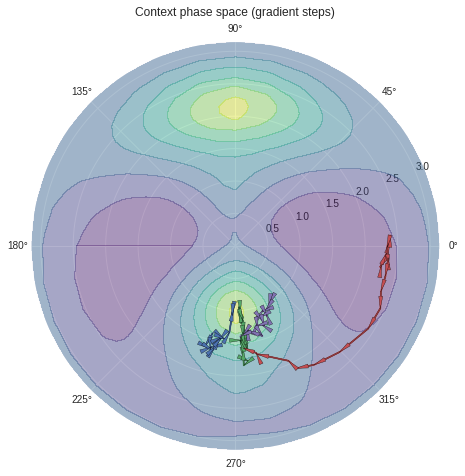

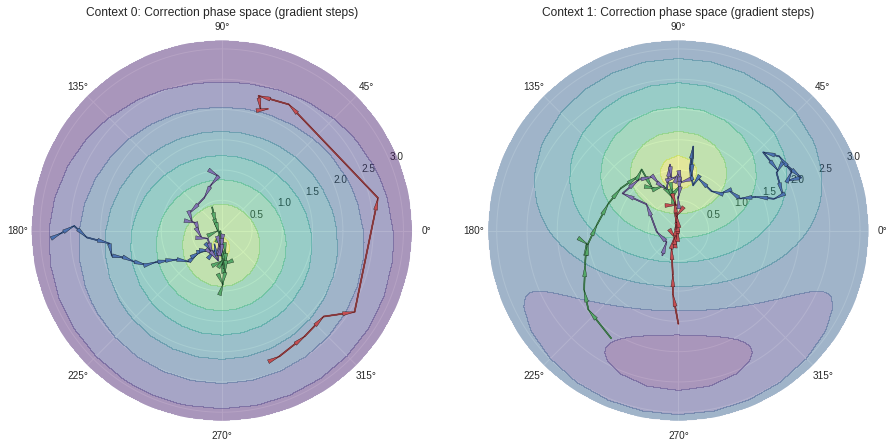

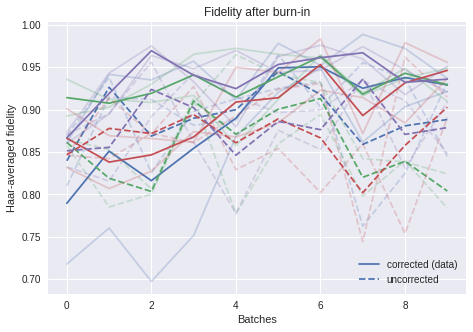

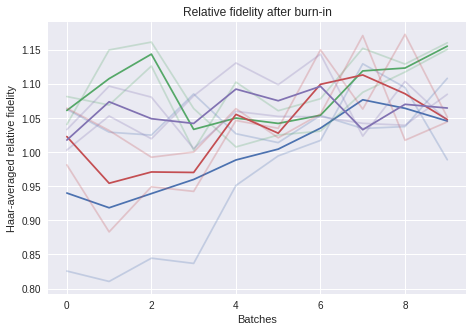

In [18]:
# Get contour over entire distribution. May need to subset for non-stationary case.
context_contour = get_contour(error_samples_generator_partial(), context_loss)
optimal_phi, optimal_theta = context_contour['max_phi'], context_contour['max_theta']


# Allows plotting of conditioned correction contours according to the true
# optimal conditioning. Previously, we conditioned based upon the current
# estimator for conditioning.
def condition_error_samples(error_samples, optimal_phi, optimal_theta):
    polling_group = []
    prepared_basis = [snot() * basis(2, 0), snot() * sigmax() * basis(2, 0)]
    for e in error_samples:
        u = get_error_unitary(e, sensitivity=1.0)
        s = u * prepared_basis[0]
        meas = np.cos(optimal_theta / 2) * prepared_basis[0] + np.exp(
                1j * optimal_phi) * np.sin(optimal_theta / 2) * prepared_basis[1]
        meas = meas.unit()
        obj = np.real(meas.overlap(s) * s.overlap(meas))
        polling_group.append(obj > 0.5)
    return polling_group


error_samples = np.array(error_samples_generator_partial())
cond = np.array(condition_error_samples(error_samples, optimal_phi, optimal_theta))
correction_contour = {}
correction_contour[0] = get_contour(error_samples[
    cond], correction_loss)
correction_contour[1] = get_contour(error_samples[
    ~cond], correction_loss)
plot_layered(parallel_sims, context_contour, correction_contour, burnin_length=10)

In [14]:
rz(np.pi / 2) * snot() * basis(2, 0)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.5-0.5j]
 [0.5+0.5j]]

## Appendix breakdowns

In [15]:
def analytic_context_grad(meas_lo, meas_mid, meas_hi, trans):
    lo = np.array(
        [np.sqrt(t.overlap(meas_lo) * meas_lo.overlap(t)) for t in trans])
    mid = np.array(
        [np.sqrt(t.overlap(meas_mid) * meas_mid.overlap(t)) for t in trans])
    hi = np.array(
        [np.sqrt(t.overlap(meas_hi) * meas_hi.overlap(t)) for t in trans])

    mean_mid = np.mean(mid)
    mean_lo = np.mean(lo)
    mean_hi = np.mean(hi)
    var_grad = np.mean([2 * (m - mean_mid) * ((h - l) - (mean_hi - mean_lo))
                        for l, m, h in zip(lo, mid, hi)])
    return var_grad


# This is the contour of the *gradient* we actually compute using
# parameter-shift-measurable observables. Spectator qubits achieve a finite
# sampling of this expectation value.
def get_analytic_contour(error_samples, num_variational_params=11):
    prepared_basis = [snot() * basis(2, 0), snot() * sigmax() * basis(2, 0)]
    trans = [rz(sample) * prepared_basis[0] for sample in error_samples]

    variational_params = np.linspace(-np.pi, np.pi - (np.pi/128),
                                     num_variational_params)
    theta_phi_feedback = {}

    for t_1 in variational_params:
        for t_2 in variational_params:
            for t_3 in variational_params:
                t = [t_1, t_2, t_3]
                unitary_mid = (rz(t[2]) * rx(-np.pi/2) * rz(t[1]) *
                               rx(np.pi / 2) * rz(t[0]))

                theta_mid, phi_mid = extract_theta_phi(unitary_mid.dag())
                meas_mid = (np.cos(theta_mid / 2) * prepared_basis[0] + np.exp(
                    1j * phi_mid) * np.sin(theta_mid / 2) * prepared_basis[1])
                meas_mid = meas_mid.unit()

                if (theta_mid, phi_mid) in theta_phi_feedback.keys():
                    continue

                g = []
                for i in range(3):
                    t[i] += -np.pi / 2
                    unitary_lo = (rz(t[2]) * rx(-np.pi/2) * rz(t[1]) *
                                  rx(np.pi / 2) * rz(t[0]))
                    t[i] += np.pi
                    unitary_hi = (rz(t[2]) * rx(-np.pi/2) * rz(t[1]) *
                                  rx(np.pi / 2) * rz(t[0]))
                    t[i] += -np.pi / 2

                    theta_lo, phi_lo = extract_theta_phi(unitary_lo.dag())
                    theta_hi, phi_hi = extract_theta_phi(unitary_hi.dag())

                    meas_lo = (np.cos(theta_lo / 2) * prepared_basis[0]
                               + np.exp(1j * phi_lo) * np.sin(theta_lo / 2)
                               * prepared_basis[1]).unit()
                    meas_hi = (np.cos(theta_hi / 2) * prepared_basis[0]
                               + np.exp(1j * phi_hi) * np.sin(theta_hi / 2)
                               * prepared_basis[1]).unit()

                    g.append(analytic_context_grad(meas_lo=meas_lo,
                                                   meas_mid=meas_mid,
                                                   meas_hi=meas_hi,
                                                   trans=trans))

                theta_phi_feedback[(round(theta_mid, 2),
                                    round(phi_mid, 2))] = np.linalg.norm(g)

    theta_grid = []
    phi_grid = []
    feedback = []

    for (t, p), f in theta_phi_feedback.items():
        theta_grid.append(t)
        phi_grid.append(p)
        feedback.append(f)
    theta_grid = np.array(theta_grid)
    phi_grid = np.array(phi_grid)
    mesh_theta = mesh_phi = np.linspace(-np.pi, np.pi,
                                        len(variational_params ** 3))
    mesh_theta, mesh_phi = np.meshgrid(mesh_theta, mesh_phi)

    # Interpolate using radial basis kernel.
    rbf = scipy.interpolate.Rbf(theta_grid, phi_grid, feedback,
                                function='linear')
    loss = rbf(mesh_theta, mesh_phi)

    return {'mesh_phi': mesh_phi, 'mesh_theta': mesh_theta, 'loss': loss}

In [16]:
# This is very slow. O(n^3) computation, for n=num_variational_params.
context_analytic_contour = get_analytic_contour(ERROR_SAMPLES,
                                                num_variational_params=15)
print(len(context_analytic_contour['mesh_phi']))

TypeError: can't multiply sequence by non-int of type 'complex'

In [ ]:
f, a = plt.subplots(1, 1, figsize=(7.5, 7.5), subplot_kw=dict(polar=True))
CS = a.contourf(context_analytic_contour['mesh_phi'],
                context_analytic_contour['mesh_theta'],
                context_analytic_contour['loss'])
a.scatter(x=[np.pi/2], y=[np.pi/2], label='ideal')
# a.clabel(CS, inline=True, fontsize=14, colors='r',
#          manual=[(-np.pi/2, np.pi/2)])
a.legend()
a.set_title("True analytic context gradient magnitude")

cbar = f.colorbar(CS)
f.show()